# Setup

In [ ]:
!pip install scanpy -q
!pip install numpy -q
!pip install pandas -q
!pip install AnnData -q
!pip install mnnpy -q
!pip install scanorama -q
!pip install wishbone_dev -q
!pip install Phenograph
!pip install scipy==1.3.0
!pip install scprep -q
!pip install matplotlib==3.1.2 -q
!pip install palantir -q

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import mnnpy 
import scprep
import scanorama
import scanpy.external as sce
import palantir

In [ ]:
!pip install scvi-colab -q
from scvi_colab import install
install()

import scvi

     |████████████████████████████████| 229 kB 5.4 MB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
INFO     scvi-colab: Installing scvi-tools.                                                  
INFO     scvi-colab: Install successful. Testing import.                                     


Global seed set to 0


# Blattman E.coli annotation + data preprocessing

In [ ]:
blattman_ecoli = sc.read('/Blattman data/GSM4192509_394A_R2_trimmed_v4_v11_threshold_1_unfiltered_gene_matrix.txt', delimiter = '\t')
blattman_ecoli

AnnData object with n_obs × n_vars = 29548 × 2423

In [ ]:
express = []
for i in blattman_ecoli.obs_names:
    if 'none' in i:
        express.append('none')
    elif 'RFP' in i:
        express.append('RFP')
    elif 'GFP' in i:
        express.append('GFP')
blattman_ecoli.obs['express']= express
blattman_ecoli.obs  

,express
394A_bc1_10_bc2_10_bc3_79_none_0,none
394A_bc1_10_bc2_11_bc3_7_GFP_1,GFP
394A_bc1_10_bc2_12_bc3_14_none_2,none
394A_bc1_10_bc2_12_bc3_83_GFP_3,GFP
394A_bc1_10_bc2_14_bc3_23_none_4,none
...,...
394A_bc1_9_bc2_95_bc3_50_none_29543,none
394A_bc1_9_bc2_9_bc3_36_RFP_29544,RFP
394A_bc1_9_bc2_9_bc3_50_GFP_29545,GFP
394A_bc1_9_bc2_9_bc3_60_none_29546,none


In [ ]:
sc.pp.calculate_qc_metrics(blattman_ecoli, inplace= True)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_qc.py:422: RuntimeWarning: invalid value encountered in true_divide
  return values / sums[:, None]


In [ ]:
dense2 = blattman_ecoli.copy()
dense2 = dense2[:,:2418]
sc.pp.filter_cells(dense2,min_counts=15)
sc.pp.filter_cells(dense2,max_counts = 2000)
sc.pp.filter_genes(dense2,min_cells = 5)

In [ ]:
pre_scVI_blatt = dense2.copy()

In [ ]:
sc.pp.normalize_total(dense2, inplace = True)
dense2.obs['cell_sum']=dense2.X.sum(axis=1)
dense2.obs['cell_sum']

394A_bc1_10_bc2_10_bc3_79_none_0       201.000031
394A_bc1_10_bc2_11_bc3_7_GFP_1         200.999985
394A_bc1_10_bc2_12_bc3_83_GFP_3        201.000015
394A_bc1_10_bc2_15_bc3_43_none_5       201.000000
394A_bc1_10_bc2_15_bc3_7_GFP_6         201.000000
                                          ...    
394A_bc1_9_bc2_95_bc3_37_none_29540    201.000000
394A_bc1_9_bc2_95_bc3_43_GFP_29541     201.000031
394A_bc1_9_bc2_9_bc3_36_RFP_29544      201.000000
394A_bc1_9_bc2_9_bc3_50_GFP_29545      201.000031
394A_bc1_9_bc2_9_bc3_84_none_29547     200.999985
Name: cell_sum, Length: 12255, dtype: float32

In [ ]:
sc.pp.log1p(dense2)
sc.pp.scale(dense2,max_value=10)

In [ ]:
dense2

AnnData object with n_obs × n_vars = 12255 × 1983
    obs: 'express', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'cell_sum'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'

# Kuchina E.coli data annotation


*  Create Anndata with annotations from Kuchina files
*  Separate B.sub from E.coli data
*  Annotate E.coli gene names from preexisting database
*  Add annotations for E.coli gene names not in database using manually curated database





In [ ]:
bsub_ecoli_file = '/content/drive/MyDrive/BMEN4480 Project/kushina_files/GSM4594094_M11_dcm.csv'
bsub_ecoli_barcodes_file = '/content/drive/MyDrive/BMEN4480 Project/kushina_files/GSM4594094_M11_barcodes.csv'
bsub_ecoli_genes_file = '/content/drive/MyDrive/BMEN4480 Project/kushina_files/GSM4594094_M11_genes.csv'

bsub_ecoli = sc.read_csv(bsub_ecoli_file, delimiter=',', first_column_names=None, dtype='float32')
barcodes = pd.read_csv(bsub_ecoli_barcodes_file,header=None)
genes = pd.read_csv(bsub_ecoli_genes_file,header=None)

bsub_ecoli.obs['barcodes'] = barcodes.to_numpy()
bsub_ecoli.var['genes'] = genes.to_numpy()

sc.pp.calculate_qc_metrics(bsub_ecoli, inplace= True)

In [ ]:
well = []
barcodes_np = barcodes.to_numpy();

for x in barcodes_np:
  if x[0][18] != '_':
    well.append(int(x[0][17:19]))
  else:
    well.append(int(x[0][17]))

well_num = np.array(well)
print(well_num)

heat_condition = np.where(well_num > 24,
                  'HS',
                  'None')
print(heat_condition)
bsub_ecoli.obs['heat_condition'] = heat_condition

[41 12  1 ... 12 35 21]
['HS' 'None' 'None' ... 'None' 'HS' 'None']


In [ ]:
strain = []
genes_np = genes.to_numpy();

for x in genes_np:
  strain.append(x[0][-5:])

strain_name = np.array(strain)
print(strain_name)

bsub_ecoli.var['strain_name'] = strain_name

# cell x gene
bsub_ecoli_copy = bsub_ecoli.copy()
bsub_ecoli_copy

['BSUBT' 'BSUBT' 'BSUBT' ... 'BSUBT' 'BSUBT' 'BSUBT']


AnnData object with n_obs × n_vars = 2682 × 7568
    obs: 'barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'heat_condition'
    var: 'genes', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'strain_name'

In [ ]:
ecoli_kuchina = bsub_ecoli_copy[:,bsub_ecoli_copy.var['strain_name'] == 'ECOLI']

In [ ]:
# change file address if needed
ecoli_gene_identifiers_raw = np.loadtxt('/content/drive/MyDrive/BMEN4480 Project/ecoli_identifier_mappings.txt', skiprows=1, delimiter="\t", unpack=False,dtype='str')

t = np.array([(g == 'Gene Name') for g in ecoli_gene_identifiers_raw[:,2]])
idx = [i for i, x in enumerate(t) if x]
select = np.in1d(range(ecoli_gene_identifiers_raw.shape[0]), idx )
ecoli_gene_identifiers = ecoli_gene_identifiers_raw[select,:]

# extracted gene names from mappings database
ecoli_gene_identifiers

array([['ER3413_4519', 'thrL', 'Gene Name'],
       ['ER3413_1', 'thrA', 'Gene Name'],
       ['ER3413_2', 'thrB', 'Gene Name'],
       ...,
       ['ER3413_4513', 'arcA', 'Gene Name'],
       ['ER3413_4541', 'yjjY', 'Gene Name'],
       ['ER3413_4514', 'yjtD', 'Gene Name']], dtype='<U18')

In [ ]:
# map gene names by their corresponding lotus tag
ecoli_genes = []
for g in ecoli_kuchina.var['genes']:
  g = g[:len(g) - 6]
  result = [x for i, x in enumerate(ecoli_gene_identifiers) if x[0] == g]
  gene_name = ''
  if len(result) == 0:
    gene_name = 'Unknown'
  else:
    gene_name = result[0][1]
  ecoli_genes.append(gene_name)

print(ecoli_genes)
print(sum('Unknown' in s for s in ecoli_genes)) #should be 191 for unfiltered e.coli cells 

ecoli_kuchina.var['gene_names'] = ecoli_genes

['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'rplC', 'Unknown', 'Unknown', 'Unknown', 'rpmF', 'raiA', 'Unknown', 'Unknown', 'Unknown', 'infC', 'Unknown', 'rplN', 'Unknown', 'rpsB', 'Unknown', 'rpsD', 'cspE', 'rpmD', 'rplO', 'rpsI', 'secY', 'ompA', 'rpsK', 'ompC', 'greA', 'rplB', 'yfeH', 'bolA', 'atpH', 'atpE', 'atpF', 'clpB', 'Unknown', 'Unknown', 'rstB', 'rplJ', 'mrcA', 'tpx', 'Unknown', 'Unknown', 'ackA', 'yadG', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'treC', 'rpoC', 'clpS', 'emrD', 'lpxD', 'hldE', 'Unknown', 'hisJ', 'Unknown', 'yhjJ', 'ptsH', 'smpB', 'Unknown', 'Unknown', 'Unknown', 'rpoB', 'fusA', 'tgt', 'trpA', 'pssA', 'rhlE', 'rplP', 'rplE', 'oppA', 'gnd', 'yoeB', 'yecF', 'rplW', 'gloA', 'frdC', 'rpmA', 'tufA', 'rseP', 'asnS', 'atpA', 'lpd', 'pitA', 'rpoA', 'fabG', 'Unknown', 'glmM', 'pspA', 'hemG', 'rseA', 'rplA', 'Unknown', 'alaS', 'Unknown', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  app.launch_new_instance()


In [ ]:
# map unknown gene names by their corresponding lotus tag using original database
ecoli_gene_unknown = pd.read_csv('/content/drive/MyDrive/BMEN4480 Project/ecoli_kuchina_unknown_genes.csv')

for g in ecoli_kuchina.var[ecoli_kuchina.var['gene_names'] == 'Unknown']['genes']:

  result = ecoli_gene_unknown.loc[ecoli_gene_unknown['genes'] == g]
  gene_name = result['gene_names'].values[0]
  ecoli_kuchina.var['gene_names'][ecoli_kuchina.var['genes'] == g] = gene_name

ecoli_kuchina.var_names = ecoli_kuchina.var['gene_names']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
ecoli_kuchina.obs_names = ecoli_kuchina.obs['barcodes']

# Kuchina E.Coli data preprocessing

Filtering cells & genes

*  Normalizing by mean count
*  Log transformation
*   Regressing out library size effects
*   Scaling

Visualization

*   Louvain clustering
*   PCA anaylsis
*   UMAP, tSNE embeddings




In [ ]:
# filter cells and genes
sc.pp.filter_cells(ecoli_kuchina, min_genes = 100)
print('Number of cells after min filter: {:d}'.format(ecoli_kuchina.n_obs))

sc.pp.filter_cells(ecoli_kuchina, min_counts = 100)
print('Number of cells after min filter: {:d}'.format(ecoli_kuchina.n_obs))

sc.pp.filter_genes(ecoli_kuchina, min_cells = 5)
print('Number of genes after min filter: {:d}'.format(ecoli_kuchina.n_vars))

Number of cells after min filter: 1063
Number of cells after min filter: 1063
Number of genes after min filter: 2692


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# copy raw data that is not tranformed
pre_scVI_kuchina = ecoli_kuchina.copy()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
mean_n_count = np.mean(ecoli_kuchina.obs["total_counts"])
print(mean_n_count)

sc.pp.normalize_total(ecoli_kuchina, target_sum=mean_n_count, copy=False)
print(ecoli_kuchina.X.sum(axis=1))

sc.pp.log1p(ecoli_kuchina)
sc.pp.regress_out(ecoli_kuchina, ['total_counts'])
sc.pp.scale(ecoli_kuchina, max_value=10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


10860.798828125
[10860.799 10860.799 10860.8   ... 10860.8   10860.799 10860.799]


In [ ]:
sc.tl.rank_genes_groups(ecoli_kuchina, 'heat_condition', method='wilcoxon')
sc.pl.rank_genes_groups(ecoli_kuchina)

In [ ]:
sc.pp.pca(ecoli_kuchina)
sc.tl.tsne(adata=ecoli_kuchina, n_pcs=5, perplexity=30)

sc.pl.tsne(ecoli_kuchina)
sc.pl.pca(ecoli_kuchina)

In [ ]:
sc.tl.pca(ecoli_kuchina, svd_solver='arpack')
sc.pl.pca_variance_ratio(ecoli_kuchina, log=True, n_pcs=50, save='') # scanpy generates the filename automatically

In [ ]:
sc.pp.neighbors(ecoli_kuchina, n_neighbors=45, n_pcs=9)
sc.tl.louvain(ecoli_kuchina, resolution = 0.4, key_added = "louvain_0.4")
sc.pl.umap(ecoli_kuchina, color=['louvain_0.4','heat_condition'],  wspace=0.2)

In [ ]:
sc.pl.umap(ecoli_kuchina, color=['ECOLI','BSUBT'], gene_symbols='strain_name', vmin=0,wspace=0.2)

In [ ]:
sc.pl.tsne(ecoli_kuchina, color=['louvain_0.4','heat_condition'],  wspace=0.2)
sc.pl.tsne(ecoli_kuchina, color=['ECOLI','BSUBT'], gene_symbols='strain_name', vmin=0,wspace=0.2)

# Trajectory analysis on Kuchina E.coli data (Wishbone)

In [ ]:
i = ecoli_kuchina.obs[ecoli_kuchina.obs['heat_condition'] == 'None']['n_genes_by_counts'].idxmax()
starting_cell = ecoli_kuchina.obs.iloc[i,:]['barcode']
ecoli_kuchina.obs_names = ecoli_kuchina.obs['barcodes']
sc.pp.neighbors(ecoli_kuchina)
sc.tl.diffmap(ecoli_kuchina, n_comps=10)

In [ ]:
sce.tl.wishbone(
    adata=ecoli_kuchina, start_cell=starting_cell,
    components=[2, 3], num_waypoints=150, branch=True
)

In [ ]:
sc.pl.tsne(ecoli_kuchina, color=['branch_wishbone', 'trajectory_wishbone'], colorbar_loc='none')

# Batch correction using MNNpy

In [ ]:
overlap_genes = np.intersect1d(ecoli_kuchina.var['gene_names'],dense2.var_names)
print(len(overlap_genes))

In [ ]:
ecoli_kuchina_filtered = ecoli_kuchina.copy()
genes_list_1 = ecoli_kuchina_filtered.var['gene_names'].tolist();
idx_1 = []
for gene in overlap_genes:
  t = genes_list_1.index(gene)
  idx_1.append(t)

ecoli_kuchina_filtered = ecoli_kuchina_filtered[:,idx_1]

ecoli_blattman_filtered = dense2.copy()
genes_list_2 = ecoli_blattman_filtered .var_names.tolist();
idx_2 = []
for gene in overlap_genes:
  t = genes_list_2.index(gene)
  idx_2.append(t)

ecoli_blattman_filtered = ecoli_blattman_filtered[:,idx_2]

print(ecoli_kuchina_filtered)
print(ecoli_blattman_filtered)

In [ ]:
ecoli_kuchina_filtered.var_names = ecoli_kuchina_filtered.var['gene_names']

In [ ]:
ecoli_kuchina_filtered.obs['batch'] = [0] * ecoli_kuchina_filtered.n_obs
ecoli_blattman_filtered.obs['batch']= [1] * ecoli_blattman_filtered.n_obs

In [ ]:
ecoli = ecoli_kuchina_filtered.concatenate(ecoli_blattman_filtered, index_unique=None)
datasets_mnn = [ecoli[ecoli.obs['batch'] == ph].copy() for ph in ecoli.obs.batch.cat.categories]

In [ ]:
corrected = mnnpy.mnn_correct(*datasets_mnn,k=50)
adata = corrected[0]

In [ ]:
sc.pp.neighbors(adata, n_neighbors=45, n_pcs=9)
sc.tl.umap(adata)
sc.pl.umap(adata,color='batch')

In [ ]:
# this is the uncorrected concatenation of the two datasets for comparison 
sc.pp.neighbors(ecoli, n_neighbors=45, n_pcs=9)
sc.tl.umap(ecoli)
sc.pl.umap(ecoli, color='batch')

# Prepare & set expectations for dataset augmentation

In [ ]:
pre_scVI_blatt 

AnnData object with n_obs × n_vars = 12255 × 1983
    obs: 'express', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [ ]:
pre_scVI_kuchina

AnnData object with n_obs × n_vars = 1063 × 2692
    obs: 'barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'heat_condition', 'n_genes', 'n_counts'
    var: 'genes', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'strain_name', 'gene_names', 'n_cells'

In [ ]:
scVI_ecoli_kuchina = pre_scVI_kuchina
scVI_ecoli_blattman = pre_scVI_blatt

In [ ]:
kuchina_unique = set(scVI_ecoli_kuchina.var_names)
print("No of unique items in the kuchina list are:", len(kuchina_unique))

blattman_unique = set(scVI_ecoli_blattman.var_names)
print("No of unique items in the blattman list are:", len(blattman_unique))

No of unique items in the kuchina list are: 2659
No of unique items in the blattman list are: 1983


In [ ]:
overlap_genes = np.intersect1d(scVI_ecoli_kuchina.var_names,scVI_ecoli_blattman.var_names)
overlap_gene_num = len(overlap_genes)
print("No of overlapping genes between kuchina and blattman:", overlap_gene_num)
print("No of genes to append to the kuchina gene list are:", len(blattman_unique) - overlap_gene_num)
print("No of genes to append to the blattman gene list are:", len(kuchina_unique) - overlap_gene_num)
print("Final no of genes for each augmented dataset should be:", len(blattman_unique) + len(kuchina_unique) + overlap_gene_num)

No of overlapping genes between kuchina and blattman: 921
No of genes to append to the kuchina gene list are: 1062
No of genes to append to the blattman gene list are: 1738
Final no of genes for each augmented dataset should be: 5563


# Preparation of Kuchina E.Coli dataset for scVI
- Returns new_ecoli_kuchina

In [ ]:
# concatenate count values for the same genes
scVI_ecoli_kuchina_df = pd.DataFrame(scVI_ecoli_kuchina.X, index=scVI_ecoli_kuchina.obs_names, columns=scVI_ecoli_kuchina.var_names).groupby(lambda x:x, axis=1).sum()
scVI_ecoli_kuchina_df

gene_names,aaeA,aaeB,aaeR,aas,aat,accA,accB,accC,accD,aceA,...,zntA,zntR,znuA,znuB,znuC,zraR,zraS,zupT,zur,zwf
barcodes,,,,,,,,,,,,,,,,,,,,,
AAACATCGAAGACGGA_1_20200401_M11_0510_K12_168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATCGCCGACAAC_8_20200401_M11_0510_K12_168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATCGCGCATACA_16_20200401_M11_0510_K12_168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATCGTCTTCACA_31_20200401_M11_0510_K12_168,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACAACCAACAGATTC_33_20200401_M11_0510_K12_168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCACCGACAAC_34_20200401_M11_0510_K12_168,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTCACGCACCTAATCC_21_20200401_M11_0510_K12_168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TTCACGCACTAAGGTC_27_20200401_M11_0510_K12_168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scVI_ecoli_kuchina_ad = ad.AnnData(X=scVI_ecoli_kuchina_df)
scVI_ecoli_kuchina_ad.obs_names = scVI_ecoli_kuchina.obs_names
scVI_ecoli_kuchina_ad.var_names = scVI_ecoli_kuchina_df.columns

In [ ]:
# should have same var as the unique number of genes in original dataset
scVI_ecoli_kuchina_ad

AnnData object with n_obs × n_vars = 1063 × 2659

In [ ]:
# genes to add to kuchina
additional_genes_for_kuchina = set(scVI_ecoli_blattman.var_names).symmetric_difference(overlap_genes)
print(len(additional_genes_for_kuchina))

1062


In [ ]:
addition_for_kuchina = np.zeros([scVI_ecoli_kuchina.n_obs, len(additional_genes_for_kuchina)])
addition_for_kuchina_df = pd.DataFrame(addition_for_kuchina, index=scVI_ecoli_kuchina.obs_names, columns=additional_genes_for_kuchina)

addition_for_kuchina_ad = ad.AnnData(X=addition_for_kuchina_df)
addition_for_kuchina_ad.obs_names = scVI_ecoli_kuchina.obs_names
addition_for_kuchina_ad.var_names = additional_genes_for_kuchina

addition_for_kuchina_ad.obs_names_make_unique()
scVI_ecoli_kuchina_ad.obs_names_make_unique()
scVI_ecoli_kuchina_ad.var_names_make_unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  after removing the cwd from sys.path.


In [ ]:
new_ecoli_kuchina = ad.concat([scVI_ecoli_kuchina_ad, addition_for_kuchina_ad], axis=1)
new_ecoli_kuchina

AnnData object with n_obs × n_vars = 1063 × 3721

In [ ]:
new_ecoli_kuchina.obs

""
barcodes
AAACATCGAAGACGGA_1_20200401_M11_0510_K12_168
AAACATCGCCGACAAC_8_20200401_M11_0510_K12_168
AAACATCGCGCATACA_16_20200401_M11_0510_K12_168
AAACATCGTCTTCACA_31_20200401_M11_0510_K12_168
AACAACCAACAGATTC_33_20200401_M11_0510_K12_168
...
TTCACGCACCGACAAC_34_20200401_M11_0510_K12_168
TTCACGCACCTAATCC_21_20200401_M11_0510_K12_168
TTCACGCACTAAGGTC_27_20200401_M11_0510_K12_168


In [ ]:
well = []
barcodes_np = new_ecoli_kuchina.obs_names.to_numpy();

for x in barcodes_np:
  if x[18] != '_':
    well.append(int(x[17:19]))
  else:
    well.append(int(x[17]))

well_num = np.array(well)

heat_condition = np.where(well_num > 24,
                  'HS',
                  'None')

new_ecoli_kuchina.obs['heat_condition'] = heat_condition

In [ ]:
new_ecoli_kuchina

AnnData object with n_obs × n_vars = 1063 × 3721
    obs: 'heat_condition'

# Preparation of Blattman dataset for scVI
- Returns new_ecoli_blattman



In [ ]:
# genes to add to blattman
additional_genes_for_blattman = set(scVI_ecoli_kuchina.var_names).symmetric_difference(overlap_genes)
print(len(additional_genes_for_blattman))

1738


In [ ]:
addition_for_blattman = np.zeros([scVI_ecoli_blattman.n_obs, len(additional_genes_for_blattman)])

addition_for_blattman_df = pd.DataFrame(addition_for_blattman, index=scVI_ecoli_blattman.obs_names, columns=additional_genes_for_blattman)
addition_for_blattman_df

,yggU,zraS,rpmG,uvrY,obgE,menD,tdcG,spf,hldE,rnlA,...,hslV,caiB,yigB,glpR,tdh,deaD,rrlA,rplK,ybgL,gpsA
394A_bc1_10_bc2_10_bc3_79_none_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394A_bc1_10_bc2_11_bc3_7_GFP_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394A_bc1_10_bc2_12_bc3_83_GFP_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394A_bc1_10_bc2_15_bc3_43_none_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394A_bc1_10_bc2_15_bc3_7_GFP_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394A_bc1_9_bc2_95_bc3_37_none_29540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394A_bc1_9_bc2_95_bc3_43_GFP_29541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394A_bc1_9_bc2_9_bc3_36_RFP_29544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394A_bc1_9_bc2_9_bc3_50_GFP_29545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
addition_for_blattman_ad = ad.AnnData(X=addition_for_blattman_df)
addition_for_blattman_ad.obs_names = scVI_ecoli_blattman.obs_names
addition_for_blattman_ad.var_names = additional_genes_for_blattman

addition_for_blattman_ad.obs_names_make_unique()
scVI_ecoli_blattman.obs_names_make_unique()
scVI_ecoli_blattman.var_names_make_unique()

new_ecoli_blattman = ad.concat([scVI_ecoli_blattman, addition_for_blattman_ad], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [ ]:
express = []
for i in new_ecoli_blattman.obs_names:
    if 'none' in i:
        express.append('none')
    elif 'RFP' in i:
        express.append('RFP')
    elif 'GFP' in i:
        express.append('GFP')
new_ecoli_blattman.obs['express']= express
new_ecoli_blattman.obs  

,express
394A_bc1_10_bc2_10_bc3_79_none_0,none
394A_bc1_10_bc2_11_bc3_7_GFP_1,GFP
394A_bc1_10_bc2_12_bc3_83_GFP_3,GFP
394A_bc1_10_bc2_15_bc3_43_none_5,none
394A_bc1_10_bc2_15_bc3_7_GFP_6,GFP
...,...
394A_bc1_9_bc2_95_bc3_37_none_29540,none
394A_bc1_9_bc2_95_bc3_43_GFP_29541,GFP
394A_bc1_9_bc2_9_bc3_36_RFP_29544,RFP
394A_bc1_9_bc2_9_bc3_50_GFP_29545,GFP


In [ ]:
new_ecoli_blattman

AnnData object with n_obs × n_vars = 12255 × 3721
    obs: 'express'

In [ ]:
new_ecoli_blattman.obs['batch']= 'blattman'
new_ecoli_kuchina.obs['batch'] = 'kuchina'

In [ ]:
concat_mnn = ad.concat([new_ecoli_blattman,new_ecoli_kuchina])
sc.pp.log1p(concat_mnn)

In [ ]:
concat_mnn.strings_to_categoricals()
concat_datasets_mnn = [concat_mnn[concat_mnn.obs['batch'] == ph].copy() for ph in concat_mnn.obs.batch.cat.categories]

In [ ]:
concat_corrected = mnnpy.mnn_correct(*concat_datasets_mnn,k=2000)
concat_adata = corrected[0]

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...


/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/python3.7/dist-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^



  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


NameError: ignored

In [ ]:
concat_adata

In [ ]:
sc.pp.neighbors(concat_adata, n_neighbors=45, n_pcs=9)
sc.tl.umap(concat_adata)
sc.pl.umap(concat_adata,color=['batch'])

# Running scVI

In [ ]:
concat_scVI = ad.concat([new_ecoli_blattman,new_ecoli_kuchina])

In [ ]:
express = []
for i in concat_scVI.obs_names:
    if 'none' in i:
        express.append('none')
    elif 'RFP' in i:
        express.append('RFP')
    elif 'GFP' in i:
        express.append('GFP')
    else:
        express.append('GFP')

concat_scVI.obs['express']= express

In [ ]:
well = []
barcodes_np = concat_scVI.obs_names.to_numpy();

for x in barcodes_np:
  if x[0] == '3':
    well.append(0)
    continue
  if x[18] != '_':
    well.append(int(x[17:19]))
  else:
    well.append(int(x[17]))

well_num = np.array(well)
print(well_num)
heat_condition = np.where(well_num > 24,
                  'HS',
                  'None')

concat_scVI.obs['heat_condition'] = heat_condition

[ 0  0  0 ... 27 46 35]


In [ ]:
concat_scVI.layers['counts'] = concat_scVI.X.copy()

In [ ]:
scvi.model.SCVI.setup_anndata(
    concat_scVI,
    layer="counts",
    batch_key = 'batch'
)

# Only run this section to retrain scVI model!

In [ ]:
model = scvi.model.SCVI(concat_scVI)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
model.train(max_epochs=400, use_gpu=0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:438: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 400/400: 100%|██████████| 400/400 [08:07<00:00,  1.22s/it, loss=144, v_num=1]


In [ ]:
# !mkdir "/content/drive/My Drive/BMEN4480 Project/scVI_model"
model.save('/content/drive/My Drive/BMEN4480 Project/scVI_model/scVi_0415_400epochs_2', save_anndata=True) 

# Visualization of scVI results

In [ ]:
model = scvi.model.SCVI.load("/content/drive/My Drive/BMEN4480 Project/scVI_model/scVi_0415_400epochs_2", use_gpu=True)

INFO     File /content/drive/My Drive/BMEN4480                                               
         Project/scVI_model/scVi_0415_400epochs_2/model.pt already downloaded                


In [ ]:
latent = model.get_latent_representation()
concat_scVI.obsm['X_scVI'] = latent
concat_scVI.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

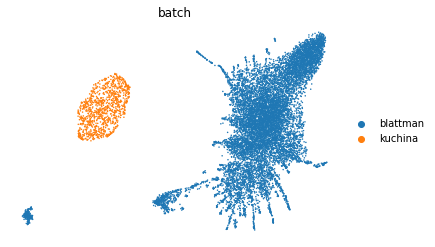

In [ ]:
# just concatenated, no scVI imputation
sc.tl.pca(concat_scVI)
sc.pp.neighbors(concat_scVI, n_pcs=30, n_neighbors=20)
sc.tl.umap(concat_scVI, min_dist=0.3)
sc.pl.umap(concat_scVI,color="batch",frameon=False)

In [ ]:
# visualize scVI latent space
sc.pp.neighbors(concat_scVI, use_rep = 'X_scVI')
sc.tl.umap(concat_scVI, min_dist=0.3)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


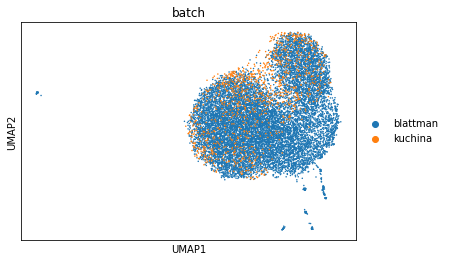

In [ ]:
sc.pl.umap(concat_scVI,color="batch")

In [ ]:
concat_scVI

AnnData object with n_obs × n_vars = 13318 × 3721
    obs: 'batch', 'express', 'heat_condition', '_scvi_batch', '_scvi_labels'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

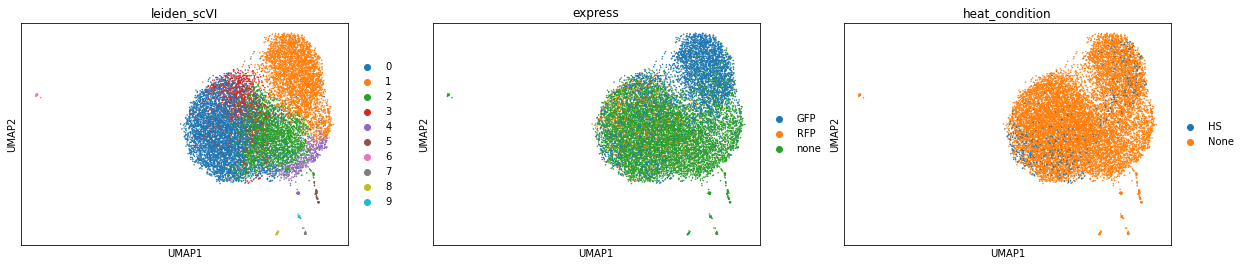

In [ ]:
# perform clustering on scVI latent space
sc.tl.leiden(concat_scVI, key_added="leiden_scVI", resolution=0.5)
sc.pl.umap(concat_scVI, color=["leiden_scVI","express","heat_condition"])

# scVi differential expression analysis

In [ ]:
concat_scVI.strings_to_categoricals()

In [ ]:
de_df2 = model.differential_expression(adata=concat_scVI, groupby="express")
de_df2.head()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
DE...: 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
ygaM,0.9824,0.0176,4.022099,7.240976e-07,9.970215e-06,0.0,0.25,-7.611434,-6.434511,7.606531,...,0.000000,0.001728,0.000000,0.001728,0.000000,0.072149,True,GFP vs Rest,GFP,Rest
hdeD,0.9804,0.0196,3.912431,3.945127e-06,4.749886e-05,0.0,0.25,-5.738719,-5.386394,5.316025,...,0.000575,0.009860,0.000575,0.009351,0.003971,0.400349,True,GFP vs Rest,GFP,Rest
pgm,0.9800,0.0200,3.891820,1.232445e-07,1.773575e-06,0.0,0.25,-5.151077,-4.639383,5.696762,...,0.072881,0.000000,0.057471,0.000000,0.071779,0.000000,True,GFP vs Rest,GFP,Rest
dcuC,0.9794,0.0206,3.861649,3.088441e-06,3.427620e-05,0.0,0.25,-6.476727,-5.407955,5.507003,...,0.000000,0.010063,0.000000,0.009758,0.000000,0.352193,True,GFP vs Rest,GFP,Rest
rpmG,0.9776,0.0224,3.776039,4.463843e-05,3.820841e-07,0.0,0.25,5.617671,5.371815,5.849998,...,0.048800,0.000000,0.044253,0.000000,0.043943,0.000000,True,GFP vs Rest,GFP,Rest


In [ ]:
markers = {}
cats = concat_scVI.obs.express.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df2.loc[de_df2.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    if cid == 'GFP vs Rest':
      cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3.5]
      cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.01]
    else:
      cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2.5]
      cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()

In [ ]:
markers

{'GFP': ['rpmG',
  'tyrT',
  'lysS',
  'prfA',
  'ybeZ',
  'tolB',
  'rpsR',
  'mlaF',
  'metU',
  'tolC',
  'rplT',
  'cysT'],
 'RFP': ['metE', 'metBL', 'metNIQ'],
 'none': ['gatYZABCD',
  'zinT',
  'dppABCDF',
  'adhE',
  'thrLABC',
  'metE',
  'focA-pflB',
  'pdhR-aceEF-lpd',
  'oppABCDF',
  'epd-pgk-fbaA']}

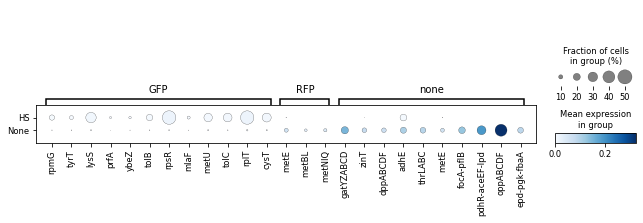

In [ ]:
sc.tl.dendrogram(concat_scVI, groupby="express", use_rep="X_scVI")

sc.pl.dotplot(
    concat_scVI,
    markers,
    groupby='heat_condition',
    dendrogram=True,
    color_map="Blues",
)

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: HS, None
var_group_labels: GFP, RFP, none


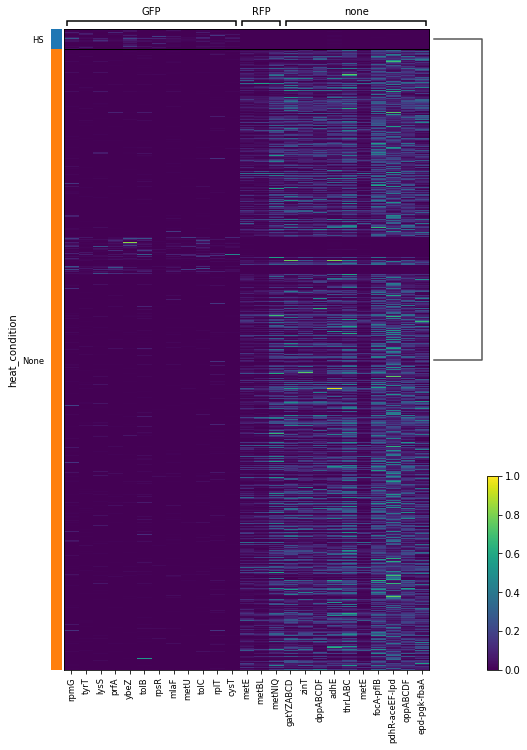

In [ ]:
sc.pl.heatmap(
    concat_scVI,
    markers,
    groupby='heat_condition',
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

In [ ]:
de_df = model.differential_expression(adata=concat_scVI, groupby="heat_condition")

DE...: 100%|██████████| 2/2 [00:22<00:00, 11.36s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2


In [ ]:
markers2 = {}
cats2 = concat_scVI.obs.heat_condition.cat.categories
for i, c in enumerate(cats2):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    if cid == 'HS vs Rest':
      cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 5.29]
      cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.01]
    else:
      cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 6.3]
      cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.001]

    markers2[c] = cell_type_df.index.tolist()

categories: GFP, Kuchina, None, etc.
var_group_labels: HS, None


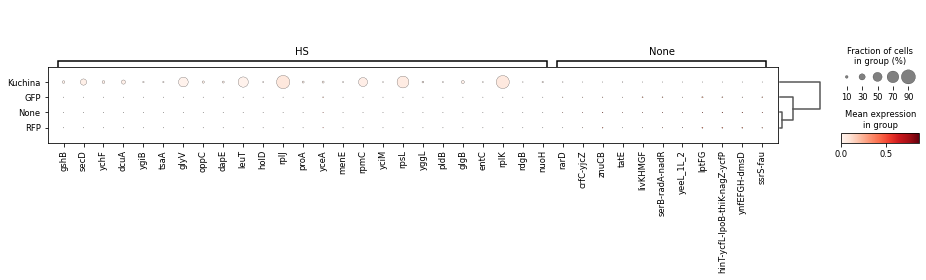

In [ ]:
sc.tl.dendrogram(concat_scVI, groupby="heat_condition", use_rep="X_scVI")

sc.pl.dotplot(
    concat_scVI,
    markers2,
    log=True,
    mean_only_expressed=True,
    groupby='express',
    dendrogram=True,
    color_map="Reds",
    smallest_dot=0.3,
)

categories: GFP, Kuchina, None, etc.
var_group_labels: HS, None


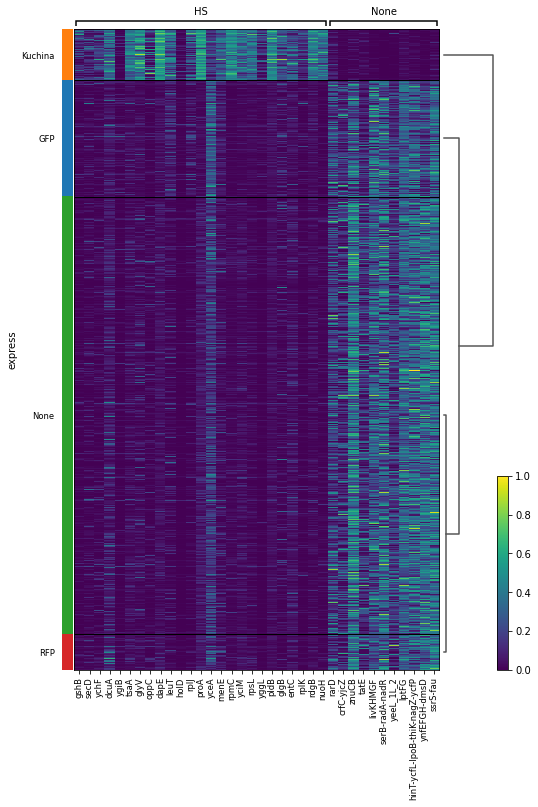

In [ ]:
sc.pl.heatmap(
    concat_scVI,
    markers2,
    groupby='express',
    layer="scvi_normalized",
    standard_scale="var",
    log=True,
    dendrogram=True,
    figsize=(8, 12),
)

In [ ]:
de_df2 = model.differential_expression(adata=concat_scVI, groupby="express")
de_df2.head()

DE...: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
bcsB,0.9762,0.0238,3.713981,2.320219e-07,0.000003,0.0,0.25,-3.342694,-3.577416,4.479512,...,0.000000,0.001559,0.000000,0.001193,0.000000,0.001204,True,GFP vs Rest,GFP,Rest
infB,0.9756,0.0244,3.688469,2.348186e-07,0.000007,0.0,0.25,-4.149244,-4.218014,4.317595,...,0.000000,0.192474,0.000000,0.065866,0.000000,0.181665,True,GFP vs Rest,GFP,Rest
yhfZ,0.9720,0.0280,3.547151,1.198253e-07,0.000001,0.0,0.25,-2.858980,-3.158818,4.275964,...,0.000000,0.001147,0.000000,0.001101,0.000000,0.000821,True,GFP vs Rest,GFP,Rest
fruBKA,0.9714,0.0286,3.525331,7.963614e-05,0.000520,0.0,0.25,-2.579630,-3.010685,3.494794,...,0.015722,0.098890,0.015308,0.081827,0.502855,4.162593,True,GFP vs Rest,GFP,Rest
glnK-amtB,0.9712,0.0288,3.518157,5.503116e-06,0.000038,0.0,0.25,-2.244585,-3.164666,4.706943,...,0.000827,0.006788,0.000827,0.006697,0.011771,0.260044,True,GFP vs Rest,GFP,Rest


In [ ]:
markers = {}
cats = concat_scVI.obs.express.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df2.loc[de_df2.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    if cid == 'Kuchina vs Rest':
      cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 18]
      cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.8]
      cell_type_df = cell_type_df[~cell_type_df.index.str.contains("rp")]
      cell_type_df = cell_type_df[~cell_type_df.index.str.contains("rr")]
    if cid == 'RFP vs Rest':
      cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2]
      cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.01]
      cell_type_df = cell_type_df[~cell_type_df.index.str.contains("-")]
    else:
      cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2.5]
      cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.01]
      cell_type_df = cell_type_df[~cell_type_df.index.str.contains("-")]

    markers[c] = cell_type_df.index.tolist()

In [ ]:
joined_string = ",".join(markers['GFP'])
print(joined_string)

fiu,fecABCDE,ghxP,sdaCB,bioA,cirA,opgC,efeOB,groSL,purMN,fhuACDB,trkA,ndk,yqaBA,yheSTU,cysB,yncE,entCEBAH,yifK,parC,mqo,yccFS,bioBFCD,codBA,rimO,opgB,eutBCLKR,rnd,exbBD,leuQPV,ispDF,yegQ,yncD,bipA,aroP,fhuF


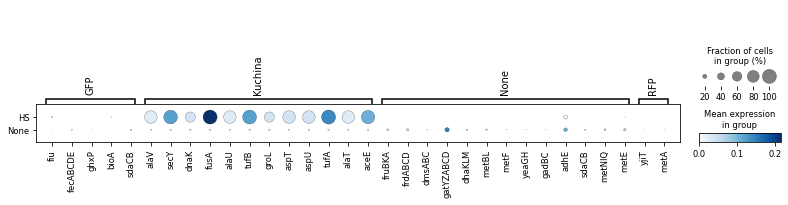

In [ ]:
sc.pl.dotplot(
    concat_scVI,
    markers,
    groupby='heat_condition',
    dendrogram=True,
    color_map="Blues",
)

categories: HS, None
var_group_labels: GFP, Kuchina, None, etc.


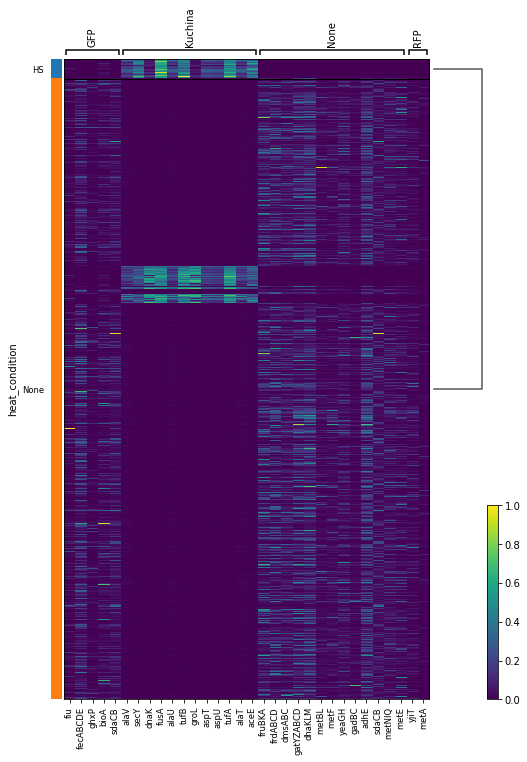

In [ ]:
sc.pl.heatmap(
    concat_scVI,
    markers,
    groupby='heat_condition',
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

In [ ]:
#save anndata in case RAM is full and aborts runtime
concat_scVI.write(filename="/concat_scVI_adata_041522_400epoch2.h5ad", compression='gzip')

# Exploration of clusters / marker genes

In [ ]:
dict_genes = scprep.stats.differential_expression_by_cluster(concat_scVI.X, concat_scVI.obs['louvain_scVI'], measure='difference', gene_names=concat_scVI.var_names, direction='both', n_jobs=-2)
dict_genes_list = list(dict_genes.items())
dict_genes_arr = np.asarray(dict_genes_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data_hvg = concat_scVI.copy()
sc.pp.highly_variable_genes(data_hvg)
data_hvg= data_hvg[:, data_hvg.var['highly_variable']]

In [ ]:
sc.pp.neighbors(data_hvg,use_rep = 'X_scVI')
sc.tl.umap(data_hvg)

In [ ]:
overlap_genes_org_hs = ['acpT', 'ansP', 'argD', 'argP', 'asnA', 'aspS', 'bacA', 'cspE',
       'cysK', 'dacD', 'dapB', 'dctA', 'dtpA', 'dtpD', 'ebgR', 'fadR',
       'fiu', 'gpt', 'gsk', 'hemB', 'hemH', 'hpt', 'inaA', 'kch', 'kup',
       'ldcC', 'loiP', 'lysR', 'malT', 'mug', 'nupC', 'ompC', 'ompF',
       'orn', 'panD', 'pgpB', 'plaP', 'ptsG', 'pykF', 'pyrC', 'pyrD',
       'queC', 'queD', 'rdgC', 'rimO', 'rlmD', 'rnd', 'rnk', 'rpmE',
       'rutR', 'suhB', 'thiI', 'trpR', 'tsaD', 'tsgA', 'yacL', 'yagU',
       'yaiI', 'ybfF', 'ybiX', 'ycaO', 'ycbZ', 'yceF', 'ydcI', 'ydeA',
       'ydgH', 'ydhP', 'yeaC', 'yeaQ', 'yedI', 'yegW', 'yeiG', 'yfcC',
       'yfiF', 'ygjR', 'yhgN', 'yicC', 'yidA', 'yieH', 'yihG', 'yiiR',
       'yiiX', 'yjfP', 'yncD', 'yoaA', 'yoaF', 'yphH', 'yraR', 'znuA']

In [ ]:
overlap_genes_org_none =['acrR', 'aidB', 'alr', 'ansB', 'clpB', 'cof', 'copA', 'cueO',
       'cysQ', 'cysZ', 'dgt', 'dsbB', 'elaA', 'elaB', 'exuR', 'fadE',
       'fbaB', 'fdhF', 'fhuF', 'galR', 'gcvB', 'gcvR', 'glmY', 'gloB',
       'glrK', 'gltP', 'grpE', 'hspQ', 'htpG', 'insG', 'insK', 'intD',
       'kdgT', 'ligB', 'lysU', 'mak', 'mdtG', 'mgsA', 'mltB', 'mngR',
       'msyB', 'mtr', 'narQ', 'ndh', 'osmB', 'proP', 'ptrB', 'purL',
       'qorB', 'queF', 'raiA', 'recN', 'rne', 'rnhA', 'selU', 'sibC',
       'slyA', 'tas', 'tatE', 'tilS', 'trxC', 'tus', 'tusA', 'tyrP',
       'uidR', 'ulaR', 'ushA', 'uspA', 'uspG', 'yahK', 'yajQ', 'ybaQ',
       'ybeL', 'ybfE', 'ybjD', 'ycbX', 'ycgN', 'ycjG', 'ydcL', 'ydfH',
       'ydgJ', 'yeeO', 'yeeX', 'yfcJ', 'yfiE', 'yfjW', 'ygiV', 'yhhQ',
       'yhiN', 'yibL', 'yicH', 'yidZ', 'yiiM', 'yjeH', 'ypfH', 'yphG',
       'yqjG', 'ytfL', 'zinT']

overlap_genes_express_gfp = ['accA', 'accD', 'acnB', 'adk', 'alaS', 'apt', 'argS', 'asnA',
       'asnS', 'aspC', 'aspS', 'can', 'cdsA', 'cirA', 'clpB', 'cspA',
       'cspE', 'dacA', 'degP', 'dnaX', 'dtpA', 'dxr', 'efp', 'fabA',
       'fabB', 'fabI', 'fadL', 'ffh', 'fhuF', 'fkpA', 'fnr', 'frr',
       'ftsK', 'galU', 'gcd', 'glnS', 'gltX', 'gmk', 'gnd', 'grpE',
       'gyrA', 'gyrB', 'hisS', 'hns', 'hrpA', 'htpG', 'hupA', 'icd',
       'kgtP', 'lipA', 'lpp', 'lysP', 'metG', 'mipA', 'mnmA', 'mqo',
       'mrcB', 'ndh', 'ndk', 'nlpI', 'ompA', 'ompF', 'ompX', 'parC',
       'pck', 'pepB', 'pgi', 'pitA', 'plaP', 'plsB', 'ppa', 'ppiD',
       'prfC', 'proP', 'proS', 'ptsG', 'purA', 'pykF', 'pyrH', 'rhlB',
       'rhlE', 'rlmN', 'rluB', 'rluC', 'rnb', 'rne', 'rplY', 'rpmE',
       'rpoH', 'rpsT', 'rseP', 'rsmB', 'serS', 'slyD', 'sodA', 'ssrA',
       'sthA', 'suhB', 'talB', 'tig', 'tktA', 'topA', 'tpx', 'trxB',
       'tsx', 'ubiD', 'wzzB', 'ybiT', 'ycaO', 'ycbZ', 'yghJ', 'ygiQ',
       'yiaF', 'yifK', 'zwf']

overlap_genes_express_rfp = ['acnB', 'adhE', 'asd', 'bglA', 'cfa', 'clpA', 'copA', 'crp',
       'cspG', 'csrB', 'cyaA', 'cysK', 'cysQ', 'dcp', 'dps', 'elaB',
       'epmA', 'fabI', 'fbaB', 'fnr', 'frr', 'ftnA', 'ftsK', 'gcvR',
       'gdhA', 'glk', 'gltX', 'glyA', 'gnd', 'gpmA', 'grcA', 'gshA',
       'gss', 'gyrB', 'hdhA', 'hisS', 'hupA', 'hupB', 'icd', 'katG',
       'lpoA', 'lpp', 'lpxP', 'lysC', 'malT', 'mdh', 'metC', 'metE',
       'metH', 'metK', 'mpl', 'mscK', 'nadB', 'nagE', 'nlpI', 'ompA',
       'ompC', 'ompF', 'ompX', 'pck', 'pdxK', 'pepD', 'pepN', 'pepT',
       'pfkA', 'pgi', 'pgl', 'pncB', 'polA', 'ppa', 'ppc', 'ppiD', 'pssA',
       'ptsG', 'purA', 'putA', 'pykA', 'pykF', 'raiA', 'rep', 'rne',
       'serA', 'slyB', 'sodB', 'ssrA', 'sstT', 'talB', 'tas', 'tktA',
       'tpiA', 'tpx', 'uspA', 'uvrA', 'wzzB', 'xseA', 'yagU', 'ybjX',
       'ydgA', 'yeeZ', 'yhfK', 'yhgF', 'yihA', 'zinT', 'znuA', 'zwf']

overlap_genes_express_none = ['acrR', 'add', 'adhE', 'adhP', 'aegA', 'aidB', 'ampC', 'amyA',
       'anmK', 'araC', 'argE', 'ascG', 'azoR', 'bdcR', 'cadC', 'cdd',
       'cfa', 'clpS', 'cpdB', 'csrB', 'csrC', 'dgkA', 'dld', 'dmlR',
       'dps', 'eco', 'elaA', 'endA', 'exuT', 'fadE', 'fbaB', 'fdhF',
       'ftnA', 'ghrA', 'gnsB', 'gntT', 'grcA', 'grxB', 'hchA', 'hdhA',
       'katE', 'metC', 'metE', 'mngR', 'msrA', 'msyB', 'mug', 'nadC',
       'narK', 'nlpC', 'osmC', 'osmY', 'pepT', 'pliG', 'purT', 'qorA',
       'raiA', 'rutR', 'sbmC', 'shiA', 'sroH', 'tatE', 'tus', 'udp',
       'ushA', 'uspA', 'uspF', 'yaaJ', 'yahK', 'ybaK', 'ybiJ', 'ybiX',
       'ybjP', 'yceB', 'yceF', 'ycgM', 'yciN', 'ydcF', 'ydcL', 'ydfG',
       'ydjM', 'yeaQ', 'yebF', 'yecA', 'yecF', 'yeeX', 'yeeY', 'yegW',
       'yeiH', 'yfbS', 'yfcZ', 'yfhH', 'ygdR', 'ygjR', 'yhhY', 'yhjD',
       'yibF', 'yicH', 'yidQ', 'yidR', 'yihD', 'yijO', 'yjeH', 'yjgR',
       'ynjE', 'yqfB', 'yqjG', 'ytfK', 'zinT', 'znuA']

In [ ]:
overlap_genes_cluster_0 = np.intersect1d(np.array(overlap_genes_org_hs),dict_genes_arr[0][1][:200].index)
overlap_genes_cluster_1 = np.intersect1d(np.array(overlap_genes_org_hs),dict_genes_arr[1][1][:100].index)
overlap_genes_cluster_2 = np.intersect1d(np.array(overlap_genes_org_hs),dict_genes_arr[2][1][:200].index)
overlap_genes_cluster_3 = np.intersect1d(np.array(overlap_genes_org_hs),dict_genes_arr[3][1][:200].index)
overlap_genes_cluster_4 = np.intersect1d(np.array(overlap_genes_org_hs),dict_genes_arr[4][1][:200].index)
overlap_genes_cluster_5 = np.intersect1d(np.array(overlap_genes_org_hs),dict_genes_arr[5][1][:200].index)
#overlap_genes_cluster_6 = np.intersect1d(np.array(overlap_genes_org_hs),dict_genes_arr[6][1][:200].index)

print(len(overlap_genes_cluster_0))
print(overlap_genes_cluster_0)

print(len(overlap_genes_cluster_1))
print(overlap_genes_cluster_1)

print(len(overlap_genes_cluster_2))
print(overlap_genes_cluster_2)

print(len(overlap_genes_cluster_3))
print(overlap_genes_cluster_3)

print(len(overlap_genes_cluster_4))
print(overlap_genes_cluster_4)

print(len(overlap_genes_cluster_5))
print(overlap_genes_cluster_5)

# print(len(overlap_genes_cluster_6))
# print(overlap_genes_cluster_6)


5
['malT' 'ompC' 'ompF' 'plaP' 'znuA']
3
['ompC' 'plaP' 'znuA']
6
['cysK' 'malT' 'ompC' 'plaP' 'ptsG' 'znuA']
7
['dtpA' 'ompC' 'ompF' 'plaP' 'ptsG' 'suhB' 'ycaO']
6
['malT' 'ompC' 'ompF' 'ptsG' 'pykF' 'znuA']
7
['aspS' 'ompC' 'ompF' 'plaP' 'ptsG' 'pykF' 'znuA']


In [ ]:
overlap_genes_cluster_none_0 = np.intersect1d(np.array(overlap_genes_org_none),dict_genes_arr[0][1][:200].index)
overlap_genes_cluster_none_1 = np.intersect1d(np.array(overlap_genes_org_none),dict_genes_arr[1][1][:200].index)
overlap_genes_cluster_none_2 = np.intersect1d(np.array(overlap_genes_org_none),dict_genes_arr[2][1][:200].index)
overlap_genes_cluster_none_3 = np.intersect1d(np.array(overlap_genes_org_none),dict_genes_arr[3][1][:200].index)

print(len(overlap_genes_cluster_none_0))
print(overlap_genes_cluster_none_0)
print(len(overlap_genes_cluster_none_1))
print(overlap_genes_cluster_none_1)
print(len(overlap_genes_cluster_none_2))
print(overlap_genes_cluster_none_2)
print(len(overlap_genes_cluster_none_3))
print(overlap_genes_cluster_none_3)

5
['htpG' 'raiA' 'rne' 'uspA' 'zinT']
4
['clpB' 'raiA' 'uspA' 'zinT']
5
['clpB' 'ndh' 'proP' 'rne' 'zinT']
6
['htpG' 'proP' 'raiA' 'rne' 'uspA' 'zinT']


In [ ]:
overlap_genes_cluster_express_gfp_0 = np.intersect1d(np.array(overlap_genes_express_gfp),dict_genes_arr[0][1][:200].index)
overlap_genes_cluster_express_gfp_1 = np.intersect1d(np.array(overlap_genes_express_gfp),dict_genes_arr[1][1][:200].index)
overlap_genes_cluster_express_gfp_2 = np.intersect1d(np.array(overlap_genes_express_gfp),dict_genes_arr[2][1][:200].index)
overlap_genes_cluster_express_gfp_3 = np.intersect1d(np.array(overlap_genes_express_gfp),dict_genes_arr[3][1][:200].index)
overlap_genes_cluster_express_gfp_4 = np.intersect1d(np.array(overlap_genes_express_gfp),dict_genes_arr[4][1][:200].index)
overlap_genes_cluster_express_gfp_5 = np.intersect1d(np.array(overlap_genes_express_gfp),dict_genes_arr[5][1][:200].index)
overlap_genes_cluster_express_gfp_6 = np.intersect1d(np.array(overlap_genes_express_gfp),dict_genes_arr[6][1][:200].index)

print(len(overlap_genes_cluster_express_gfp_0))
print(overlap_genes_cluster_express_gfp_0)

print(len(overlap_genes_cluster_express_gfp_1))
print(overlap_genes_cluster_express_gfp_1)

print(len(overlap_genes_cluster_express_gfp_2))
print(overlap_genes_cluster_express_gfp_2)

print(len(overlap_genes_cluster_express_gfp_3))
print(overlap_genes_cluster_express_gfp_3)

print(len(overlap_genes_cluster_express_gfp_4))
print(overlap_genes_cluster_express_gfp_4)
print(len(overlap_genes_cluster_express_gfp_5))
print(overlap_genes_cluster_express_gfp_5)
print(len(overlap_genes_cluster_express_gfp_6))
print(overlap_genes_cluster_express_gfp_6)

38
['acnB' 'alaS' 'asnA' 'asnS' 'cspA' 'cspE' 'dtpA' 'efp' 'fabB' 'fabI'
 'fadL' 'glnS' 'gltX' 'gyrA' 'gyrB' 'htpG' 'icd' 'kgtP' 'lpp' 'ndk' 'nlpI'
 'ompA' 'ompF' 'plaP' 'prfC' 'proS' 'ptsG' 'purA' 'pyrH' 'rne' 'rplY'
 'rpsT' 'sodA' 'suhB' 'tig' 'topA' 'ycaO' 'yghJ']
19
['acnB' 'aspC' 'clpB' 'cspA' 'fabI' 'gnd' 'icd' 'kgtP' 'lpp' 'ompA' 'ompF'
 'ompX' 'plaP' 'ppiD' 'purA' 'serS' 'ssrA' 'talB' 'yghJ']
28
['acnB' 'alaS' 'clpB' 'cspA' 'fadL' 'ftsK' 'glnS' 'gnd' 'icd' 'kgtP'
 'lipA' 'lpp' 'ndh' 'nlpI' 'ompA' 'ompF' 'pgi' 'pitA' 'plaP' 'prfC' 'proP'
 'ptsG' 'purA' 'rne' 'ssrA' 'tig' 'yghJ' 'zwf']
35
['acnB' 'alaS' 'apt' 'aspC' 'aspS' 'cspA' 'cspE' 'efp' 'fabB' 'glnS'
 'gyrA' 'hns' 'htpG' 'icd' 'lpp' 'metG' 'nlpI' 'ompA' 'ompF' 'ompX' 'pgi'
 'plaP' 'prfC' 'proP' 'proS' 'ptsG' 'rne' 'rplY' 'rpmE' 'rpsT' 'sodA'
 'ssrA' 'tig' 'tktA' 'yghJ']
35
['accA' 'acnB' 'asnS' 'aspS' 'cspA' 'efp' 'fabB' 'frr' 'gltX' 'gnd' 'gyrA'
 'gyrB' 'hisS' 'hns' 'htpG' 'icd' 'kgtP' 'lpp' 'ndh' 'nlpI' 'ompA' 'ompF'
 'om

In [ ]:
overlap_genes_cluster_express_rfp_0 = np.intersect1d(np.array(overlap_genes_express_rfp),dict_genes_arr[0][1][:200].index)
overlap_genes_cluster_express_rfp_1 = np.intersect1d(np.array(overlap_genes_express_rfp),dict_genes_arr[1][1][:200].index)
overlap_genes_cluster_express_rfp_2 = np.intersect1d(np.array(overlap_genes_express_rfp),dict_genes_arr[2][1][:200].index)
overlap_genes_cluster_express_rfp_3 = np.intersect1d(np.array(overlap_genes_express_rfp),dict_genes_arr[3][1][:200].index)
overlap_genes_cluster_express_rfp_4 = np.intersect1d(np.array(overlap_genes_express_rfp),dict_genes_arr[4][1][:200].index)
overlap_genes_cluster_express_rfp_5 = np.intersect1d(np.array(overlap_genes_express_rfp),dict_genes_arr[5][1][:200].index)
overlap_genes_cluster_express_rfp_6 = np.intersect1d(np.array(overlap_genes_express_rfp),dict_genes_arr[6][1][:200].index)

print(len(overlap_genes_cluster_express_rfp_0))
print(overlap_genes_cluster_express_rfp_0)

print(len(overlap_genes_cluster_express_rfp_1))
print(overlap_genes_cluster_express_rfp_1)

print(len(overlap_genes_cluster_express_rfp_2))
print(overlap_genes_cluster_express_rfp_2)

print(len(overlap_genes_cluster_express_rfp_3))
print(overlap_genes_cluster_express_rfp_3)

print(len(overlap_genes_cluster_express_rfp_4))
print(overlap_genes_cluster_express_rfp_4)

print(len(overlap_genes_cluster_express_rfp_5))
print(overlap_genes_cluster_express_rfp_5)

print(len(overlap_genes_cluster_express_rfp_6))
print(overlap_genes_cluster_express_rfp_6)

31
['acnB' 'adhE' 'clpA' 'csrB' 'dps' 'fabI' 'gltX' 'glyA' 'grcA' 'gyrB'
 'icd' 'katG' 'lpp' 'malT' 'metE' 'metK' 'nlpI' 'ompA' 'ompC' 'ompF'
 'pfkA' 'ppc' 'ptsG' 'purA' 'pykA' 'raiA' 'rne' 'sodB' 'uspA' 'zinT'
 'znuA']
38
['acnB' 'adhE' 'cfa' 'clpA' 'crp' 'csrB' 'cyaA' 'fabI' 'gdhA' 'glyA' 'gnd'
 'gpmA' 'hupB' 'icd' 'katG' 'lpp' 'malT' 'metE' 'ompA' 'ompC' 'ompF'
 'ompX' 'pepD' 'pfkA' 'ppc' 'ppiD' 'purA' 'raiA' 'serA' 'slyB' 'sodB'
 'ssrA' 'sstT' 'talB' 'tpiA' 'uspA' 'zinT' 'znuA']
35
['acnB' 'adhE' 'asd' 'cysK' 'dps' 'ftsK' 'glyA' 'gnd' 'grcA' 'icd' 'katG'
 'lpp' 'mdh' 'metE' 'metK' 'nlpI' 'ompA' 'ompC' 'ompF' 'pfkA' 'pgi' 'ppc'
 'ptsG' 'purA' 'pykA' 'rne' 'serA' 'sodB' 'ssrA' 'sstT' 'tpiA' 'ydgA'
 'zinT' 'znuA' 'zwf']
26
['acnB' 'adhE' 'crp' 'glyA' 'gpmA' 'icd' 'katG' 'lpp' 'metE' 'metK' 'nlpI'
 'ompA' 'ompC' 'ompF' 'ompX' 'pepD' 'pgi' 'ptsG' 'raiA' 'rne' 'serA'
 'sodB' 'ssrA' 'tktA' 'uspA' 'zinT']
34
['acnB' 'adhE' 'asd' 'cyaA' 'frr' 'gltX' 'gnd' 'gyrB' 'hisS' 'icd' 'lpp'
 'malT' '

In [ ]:
overlap_genes_cluster_express_none_0 = np.intersect1d(np.array(overlap_genes_express_none),dict_genes_arr[0][1][:200].index)
overlap_genes_cluster_express_none_1 = np.intersect1d(np.array(overlap_genes_express_none),dict_genes_arr[1][1][:200].index)
overlap_genes_cluster_express_none_2 = np.intersect1d(np.array(overlap_genes_express_none),dict_genes_arr[2][1][:200].index)
overlap_genes_cluster_express_none_3 = np.intersect1d(np.array(overlap_genes_express_none),dict_genes_arr[3][1][:200].index)
overlap_genes_cluster_express_none_4 = np.intersect1d(np.array(overlap_genes_express_none),dict_genes_arr[4][1][:200].index)
overlap_genes_cluster_express_none_5 = np.intersect1d(np.array(overlap_genes_express_none),dict_genes_arr[5][1][:200].index)
overlap_genes_cluster_express_none_6 = np.intersect1d(np.array(overlap_genes_express_none),dict_genes_arr[6][1][:200].index)

print(len(overlap_genes_cluster_express_none_0))
print(overlap_genes_cluster_express_none_0)

print(len(overlap_genes_cluster_express_none_1))
print(overlap_genes_cluster_express_none_1)

print(len(overlap_genes_cluster_express_none_2))
print(overlap_genes_cluster_express_none_2)

print(len(overlap_genes_cluster_express_none_3))
print(overlap_genes_cluster_express_none_3)

print(len(overlap_genes_cluster_express_none_4))
print(overlap_genes_cluster_express_none_4)

print(len(overlap_genes_cluster_express_none_5))
print(overlap_genes_cluster_express_none_5)

print(len(overlap_genes_cluster_express_none_6))
print(overlap_genes_cluster_express_none_6)

9
['adhE' 'csrB' 'dps' 'grcA' 'metE' 'raiA' 'uspA' 'zinT' 'znuA']
10
['adhE' 'cfa' 'csrB' 'katE' 'metE' 'raiA' 'udp' 'uspA' 'zinT' 'znuA']
6
['adhE' 'dps' 'grcA' 'metE' 'zinT' 'znuA']
5
['adhE' 'metE' 'raiA' 'uspA' 'zinT']
4
['adhE' 'metE' 'zinT' 'znuA']
7
['adhE' 'amyA' 'dps' 'metE' 'raiA' 'yfcZ' 'zinT']
6
['adhE' 'grcA' 'metE' 'uspA' 'zinT' 'znuA']


# Palantir alignment

In [ ]:
sc.external.tl.palantir(concat_scVI, n_components=10, knn=30, alpha=0, use_adjacency_matrix='X_scvi', distances_key=None, n_eigs=None, impute_data=True, n_steps=3, copy=False)

In [ ]:
sc.tl.tsne(concat_scVI, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=150)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


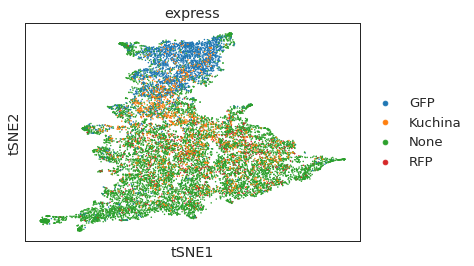

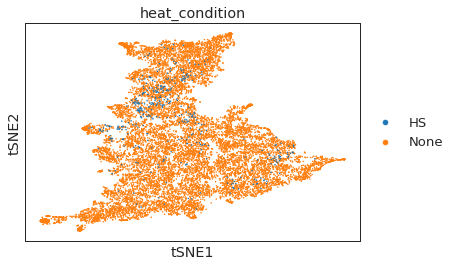

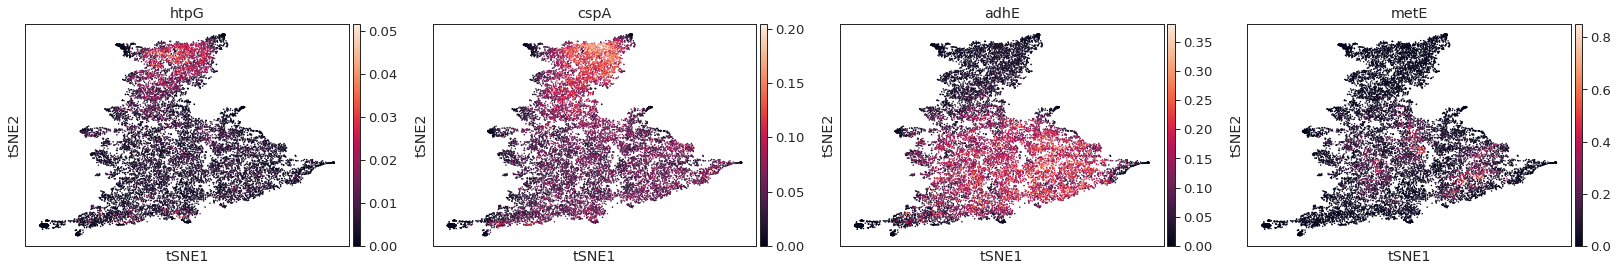

In [ ]:
sc.pl.tsne(concat_scVI,color=['express'])
sc.pl.tsne(concat_scVI,color=['heat_condition'])
sc.pl.tsne(
    concat_scVI,
    gene_symbols=['htpG','cspA','adhE','metE'],
    layer='palantir_imp',
    color=['htpG','cspA','adhE','metE']
)